In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt
import joblib
import ast

In [2]:
df = pd.read_csv("archive/clean_IMDB3.csv")
texts = df["clean_review"].apply(ast.literal_eval).apply(lambda t: " ".join(t))

In [3]:
y = df["sentiment"].map({"negative":0, "positive":1}).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, stratify=y, random_state=42
)

In [4]:
pipe = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(max_features=20000, ngram_range=(1,2))),
    ("clf", LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42))
])

In [5]:
pipe.fit(X_train, y_train)

,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [6]:
y_pred = pipe.predict(X_test)

In [7]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 (weighted):", f1_score(y_test, y_pred, average="weighted"))
print(classification_report(y_test, y_pred, target_names=["negative","positive"], zero_division=0))

Accuracy: 0.8964
F1 (weighted): 0.8963923371772576
              precision    recall  f1-score   support

    negative       0.90      0.89      0.90      5000
    positive       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



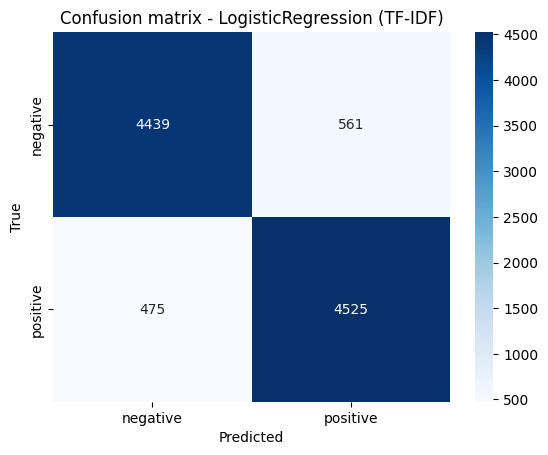

In [8]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["negative","positive"], yticklabels=["negative","positive"])
plt.title("Confusion matrix - LogisticRegression (TF-IDF)")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

In [9]:
joblib.dump(pipe, "modelML/rl/rlpipelineV2.pkl")

['modelML/rl/rlpipelineV2.pkl']

In [13]:
print(pipe.predict(["This movie is awful. Boring and badly acted."]))
print(pipe.predict(["bad"]))
print("et oui...")
print(pipe.predict(["Absolutely loved it, brilliant story and acting."]))

[1]
[0]
et oui...
[1]


## With Optimisor

In [14]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

df = pd.read_csv("archive/clean_IMDB3.csv")
texts = df["clean_review"].apply(ast.literal_eval).apply(lambda t: " ".join(t))
y = df["sentiment"].map({"negative":0, "positive":1}).astype(int)
X_train, X_test, y_train, y_test = train_test_split(texts, y, test_size=0.2, stratify=y, random_state=42)

pipe = Pipeline(steps=[
    ("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42))
])

In [15]:
param_grid = {
    "tfidf__max_features": [20000, 40000],
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [1, 2],
    "clf__C": [0.5, 1.0, 2.0],
    "clf__class_weight": [None, "balanced"]
}

In [16]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    refit=True
)

In [18]:
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("CV best score:", grid.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best params: {'clf__C': 2.0, 'clf__class_weight': None, 'tfidf__max_features': 40000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
CV best score: 0.897225


In [19]:
best_pipe = grid.best_estimator_

In [20]:
y_pred = best_pipe.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 (weighted):", f1_score(y_test, y_pred, average="weighted"))
print(classification_report(y_test, y_pred, target_names=["negative","positive"], zero_division=0))

Accuracy: 0.9015
F1 (weighted): 0.901491479998105
              precision    recall  f1-score   support

    negative       0.91      0.89      0.90      5000
    positive       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [21]:
joblib.dump(best_pipe, "modelML/rl/rlpipeline_bestV1.pkl")

['modelML/rl/rlpipeline_bestV1.pkl']

In [22]:
lastPipe = joblib.load("modelML/rl/rlpipeline_bestV1.pkl")

In [29]:
print(lastPipe.predict(["This movie is bad"]))
print(lastPipe.predict(["bad"]))
print("et oui...")
print(lastPipe.predict(["Absolutely loved it, brilliant story and acting."]))

[0]
[0]
et oui...
[1]
